In [3]:
#case_assignment3_linear_regression
import pandas as pd
from ISLP import load_data
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Load the dataset
Smarket = load_data('Smarket')

# Filter the data
train_data = Smarket[Smarket['Year'] <= 2004]
test_data = Smarket[Smarket['Year'] == 2005]

# Features and target variable
features = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']
X_train = train_data[features]
y_train = train_data['Today']

# Add constant to the training features
X_train = sm.add_constant(X_train)

# Initialize and fit the OLS model using statsmodels
ols_model = sm.OLS(y_train, X_train).fit()

# Prepare the test data
X_test = test_data[features]  # Select features for the test set
y_test = test_data['Today']   # Actual values for comparison

# Add constant to the test features
X_test = sm.add_constant(X_test)

# Predict the 'Today' variable using the OLS model
y_pred = ols_model.predict(X_test)

# Print predicted values and compare with actual
#print("Predicted values:", y_pred.values)
#print("Actual values:", y_test.values)

#summary
print(ols_model.summary())

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the performance metrics
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

                            OLS Regression Results                            
Dep. Variable:                  Today   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.3626
Date:                Wed, 02 Oct 2024   Prob (F-statistic):              0.903
Time:                        14:22:23   Log-Likelihood:                -1620.8
No. Observations:                 998   AIC:                             3256.
Df Residuals:                     991   BIC:                             3290.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0146      0.205     -0.071      0.9

In [4]:
#BEST SUBSET SELECTION METHOD 

# Step 1: Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import os

# Load the Smarket data (ensure all years are included)
from ISLP import load_data
Smarket = load_data('Smarket')

# One-hot encode the 'Direction' column
Smarket = pd.get_dummies(Smarket, columns=['Direction'], drop_first=True)

# Add Day column based on index
Smarket['Day'] = Smarket.index.copy()

# Create Year_Day feature (normalize Day within each year)
year_day_max_dict = Smarket.groupby('Year')['Day'].max().to_dict()
Smarket['Year_Day'] = Smarket.apply(lambda x: x['Year'] + x['Day'] / year_day_max_dict[x['Year']], axis=1)

# Display the updated data to ensure all years are included
print("First 5 rows of the data after preprocessing (including all years):")
print(Smarket.head())

# Step 2: Define the feature matrix X and the target variable Y ('Today' as Y)
X = Smarket[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Year_Day']]
Y = Smarket['Today']  # Target variable is 'Today' (continuous)

# Step 3: Define Cp statistic function for regression
def Cp_statistic(sigma2, X, Y, model):
    """
    Cp statistic calculation for regression
    sigma2: residual variance
    X: feature matrix
    Y: target variable (continuous)
    model: fitted model
    """
    n, p = X.shape
    Yhat = model.predict(X)
    RSS = np.sum((Y - Yhat) ** 2)
    Cp = (RSS + 2 * p * sigma2) / n
    return Cp

# Step 4: Forward Stepwise Selection for regression
def forward_stepwise_selection(X, Y, sigma2):
    """
    Forward Stepwise Selection to find the best regression model
    X: feature matrix
    Y: target variable (continuous)
    sigma2: residual variance
    """
    n_predictors = X.shape[1]
    predictors = []
    best_models = []
    
    for i in range(n_predictors):
        remaining_predictors = list(set(X.columns) - set(predictors))
        best_cp = np.inf
        best_model = None
        for predictor in remaining_predictors:
            temp_predictors = predictors + [predictor]
            X_temp = X[temp_predictors]
            model = sm.OLS(Y, sm.add_constant(X_temp)).fit()
            cp = Cp_statistic(sigma2, sm.add_constant(X_temp), Y, model)
            if cp < best_cp:
                best_cp = cp
                best_model = model
        predictors.append(best_model.model.exog_names[-1])
        best_models.append(best_model)
        print(f"Step {i+1}: Selected predictors = {predictors}, Cp = {best_cp}")
    
    return best_models

# Step 5: Calculate performance metrics for regression (MSE, R-squared, Adjusted R-squared)
def calculate_regression_metrics(models, X, Y):
    """
    Calculate regression performance metrics for each model:
    - MSE, R-squared, Adjusted R-squared
    """
    model_data = []

    for i, model in enumerate(models):
        X_model = sm.add_constant(X[model.model.exog_names[1:]])
        Yhat = model.predict(X_model)
        
        # Mean Squared Error
        mse = mean_squared_error(Y, Yhat)
        
        # OLS model statistics
        rsquared = model.rsquared
        rsquared_adj = model.rsquared_adj
        
        # Store the model data in a dictionary
        model_data.append({
            'Model': i + 1,
            'Predictors': model.model.exog_names[1:],
            'MSE': mse,
            'R-squared': rsquared,
            'Adjusted R-squared': rsquared_adj
        })
    
    df_models = pd.DataFrame(model_data)
    #print("Regression performance metrics for all models:")
    #print(df_models)

    return df_models

# Step 6: Split the data into training and test sets based on the Year
train_data = Smarket[Smarket['Year'] <= 2004]
test_data = Smarket[Smarket['Year'] == 2005]

# Step 7: Evaluate each model on training and test data
def evaluate_on_train_test(models, train_data, test_data, features, target):
    """
    Evaluate each model on both the training and test datasets.
    Calculate the training and test MSE for each model.
    """
    train_mses = []
    test_mses = []

    for i, model in enumerate(models):
        # Extract predictors for current model
        selected_features = model.model.exog_names[1:]  # Ignore constant
        
        # Train data
        X_train = sm.add_constant(train_data[selected_features])
        Y_train = train_data[target]
        train_pred = model.predict(X_train)
        #train_mse = mean_squared_error(Y_train, train_pred)
        #train_mses.append(train_mse)
        
        # Test data
        X_test = sm.add_constant(test_data[selected_features])
        Y_test = test_data[target]
        test_pred = model.predict(X_test)
        test_mse = mean_squared_error(Y_test, test_pred)
        test_mses.append(test_mse)
        
        # Print the results for each model
        print(f"Model {i+1}:")
        print(f"  Predictors: {selected_features}")
        #print(f"  Training MSE: {train_mse}")
        print(f"  Test MSE: {test_mse}")
        print("-" * 40)

    return train_mses, test_mses

# Step 8: Calculate sigma^2 and perform forward stepwise selection
model_full = sm.OLS(Y, sm.add_constant(X)).fit()
sigma2 = model_full.mse_resid
print(f"Full model sigma^2 (residual variance): {sigma2}")

best_models = forward_stepwise_selection(X, Y, sigma2)

# Step 9: Calculate performance metrics for all regression models
df_models = calculate_regression_metrics(best_models, X, Y)

# Step 10: Evaluate models on train/test data
train_mses, test_mses = evaluate_on_train_test(best_models, train_data, test_data, features=X.columns, target='Today')

# Step 11: Display the best regression model based on test MSE
best_model_idx = np.argmin(test_mses)
best_model = best_models[best_model_idx]
print(f"\nBest regression model is Model {best_model_idx+1} with predictors = {best_model.model.exog_names[1:]} and Test MSE = {test_mses[best_model_idx]}")


First 5 rows of the data after preprocessing (including all years):
   Year   Lag1   Lag2   Lag3   Lag4   Lag5  Volume  Today  Direction_Up  Day  \
0  2001  0.381 -0.192 -2.624 -1.055  5.010  1.1913  0.959          True    0   
1  2001  0.959  0.381 -0.192 -2.624 -1.055  1.2965  1.032          True    1   
2  2001  1.032  0.959  0.381 -0.192 -2.624  1.4112 -0.623         False    2   
3  2001 -0.623  1.032  0.959  0.381 -0.192  1.2760  0.614          True    3   
4  2001  0.614 -0.623  1.032  0.959  0.381  1.2057  0.213          True    4   

      Year_Day  
0  2001.000000  
1  2001.004149  
2  2001.008299  
3  2001.012448  
4  2001.016598  
Full model sigma^2 (residual variance): 1.2940657780654639
Step 1: Selected predictors = ['Lag5'], Cp = 1.292795243051345
Step 2: Selected predictors = ['Lag5', 'Year_Day'], Cp = 1.2933751857716924
Step 3: Selected predictors = ['Lag5', 'Year_Day', 'Lag1'], Cp = 1.294471095829016
Step 4: Selected predictors = ['Lag5', 'Year_Day', 'Lag1', 'Lag2'], 

Full model sigma^2 (residual variance): 1.2940657780654639
Step 1: Selected predictors = ['Lag5'], Cp = 1.292795243051345
Step 2: Selected predictors = ['Lag5', 'Year_Day'], Cp = 1.2933751857716924
Step 3: Selected predictors = ['Lag5', 'Year_Day', 'Lag1'], Cp = 1.294471095829016
Step 4: Selected predictors = ['Lag5', 'Year_Day', 'Lag1', 'Lag2'], Cp = 1.296347086848183
Step 5: Selected predictors = ['Lag5', 'Year_Day', 'Lag1', 'Lag2', 'Lag4'], Cp = 1.2983013586068772
Step 6: Selected predictors = ['Lag5', 'Year_Day', 'Lag1', 'Lag2', 'Lag4', 'Volume'], Cp = 1.3003208579260301
Step 7: Selected predictors = ['Lag5', 'Year_Day', 'Lag1', 'Lag2', 'Lag4', 'Volume', 'Lag3'], Cp = 1.3023477990450825
Model 1: Cross-validated MSE = 1.2886542325615353
Model 2: Cross-validated MSE = 1.2871636700369784
Model 3: Cross-validated MSE = 1.2861890748493967
Model 4: Cross-validated MSE = 1.2859945606236591
Model 5: Cross-validated MSE = 1.2858783271374485
Model 6: Cross-validated MSE = 1.2858273212116968


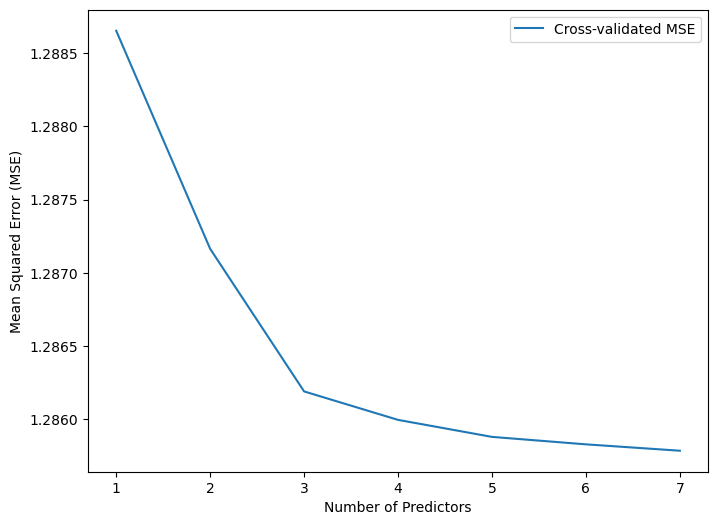

Best regression model is Model 7 with predictors = ['Lag5', 'Year_Day', 'Lag1', 'Lag2', 'Lag4', 'Volume', 'Lag3'] and Cross-validated MSE = 1.2857837570858446


In [5]:
# Step 6: Cross-validation for regression
def cross_validation(models, X, Y, k=5):
    """
    k-fold cross-validation for regression
    models: all selected models
    X: feature matrix
    Y: target variable (continuous)
    k: number of folds for cross-validation
    """
    kfold = KFold(n_splits=k)
    cv_errors = []

    for i, model in enumerate(models):
        mse_folds = []
        for train_idx, test_idx in kfold.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
            Yhat = model.predict(sm.add_constant(X_test[model.model.exog_names[1:]]))
            mse = np.mean((Y_test - Yhat) ** 2)
            mse_folds.append(mse)
        cv_error = np.mean(mse_folds)
        cv_errors.append(cv_error)
        print(f"Model {i+1}: Cross-validated MSE = {cv_error}")
    
    return cv_errors

# Step 7: Calculate sigma^2 and perform forward stepwise selection
model_full = sm.OLS(Y, sm.add_constant(X)).fit()
sigma2 = model_full.mse_resid
print(f"Full model sigma^2 (residual variance): {sigma2}")

best_models = forward_stepwise_selection(X, Y, sigma2)

# Step 8: Calculate performance metrics for all regression models
df_models = calculate_regression_metrics(best_models, X, Y)

# Step 9: Perform cross-validation and plot MSE results
cv_errors = cross_validation(best_models, X, Y, k=5)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_errors) + 1), cv_errors, label="Cross-validated MSE")
plt.xlabel("Number of Predictors")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.show()

# Step 10: Display the best regression model
best_model_idx = np.argmin(cv_errors)
best_model = best_models[best_model_idx]
print(f"Best regression model is Model {best_model_idx+1} with predictors = {best_model.model.exog_names[1:]} and Cross-validated MSE = {cv_errors[best_model_idx]}")

In [6]:
#Trying other feature selection methods

#Principal Component Regression

import pandas as pd
from ISLP import load_data
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load the dataset
Smarket = load_data('Smarket')

# Filter the data
train_data = Smarket[Smarket['Year'] <= 2004]
test_data = Smarket[Smarket['Year'] == 2005]

# Features and target variable
features = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']
X_train = train_data[features]
y_train = train_data['Today']
X_test = test_data[features]
y_test = test_data['Today']

# Step 1: Standardize the data (important for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Apply PCA to the training data
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Step 3: Determine how many principal components to keep based on explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by each component: {explained_variance}")

# Cumulative explained variance (use this to choose the number of components)
cumulative_variance = explained_variance.cumsum()
print(f"Cumulative explained variance: {cumulative_variance}")

# Let's assume we decide to keep the first 2 principal components
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Step 4: Fit the linear regression model using the principal components
lin_reg = LinearRegression()
lin_reg.fit(X_train_pca, y_train)

# Step 5: Predict the 'Today' variable using the PCR model
y_pred = lin_reg.predict(X_test_pca)

# Step 6: Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print performance metrics
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Explained Variance by each component: [0.18839889 0.17139574 0.17022302 0.16687237 0.16227389 0.14083609]
Cumulative explained variance: [0.18839889 0.35979463 0.53001765 0.69689002 0.85916391 1.        ]
Mean Squared Error: 0.42
R-squared: -0.00


In [7]:
#RECURSIVE FEATURE ELIMINATION

import pandas as pd
from ISLP import load_data
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Load the dataset
Smarket = load_data('Smarket')

# Filter the data
train_data = Smarket[Smarket['Year'] <= 2004]
test_data = Smarket[Smarket['Year'] == 2005]

# Features and target variable
features = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']
X_train = train_data[features]
y_train = train_data['Today']
X_test = test_data[features]  # Select features for the test set
y_test = test_data['Today']   # Actual values for comparison

# Initialize a linear regression model
model = LinearRegression()

# Perform RFE with the model and select a certain number of features (e.g., 3)
n_features_to_select = 3  # You can adjust this number
rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected features:", selected_features)

# Prepare the training and test sets with the selected features
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

# Add constant to the training features for OLS
X_train_rfe = sm.add_constant(X_train_rfe)

# Fit the OLS model
ols_model_rfe = sm.OLS(y_train, X_train_rfe).fit()

# Add constant to the test features for OLS
X_test_rfe = sm.add_constant(X_test_rfe)

# Predict the 'Today' variable using the OLS model
y_pred_rfe = ols_model_rfe.predict(X_test_rfe)

# Print the summary of the RFE model
print(ols_model_rfe.summary())

# Calculate performance metrics
mse_rfe = mean_squared_error(y_test, y_pred_rfe)
r2_rfe = r2_score(y_test, y_pred_rfe)

# Print the performance metrics
print(f"Mean Squared Error (RFE): {mse_rfe:.2f}")
print(f"R-squared (RFE): {r2_rfe:.2f}")

Selected features: Index(['Lag1', 'Lag5', 'Volume'], dtype='object')
                            OLS Regression Results                            
Dep. Variable:                  Today   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6765
Date:                Wed, 02 Oct 2024   Prob (F-statistic):              0.566
Time:                        14:22:27   Log-Likelihood:                -1620.9
No. Observations:                 998   AIC:                             3250.
Df Residuals:                     994   BIC:                             3269.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [8]:
#RECURSIVE FEATURE ELIMINATION with feature engineering

import pandas as pd
from ISLP import load_data
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the dataset
Smarket = load_data('Smarket')

# Filter the data
data = Smarket.copy()
data = data.dropna()  # Dropping rows with NaN values

# Features and target variable
features = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']
X = data[features]
y = data['Today']

# Feature Engineering
# 1. Create additional lag features
data['Lag6'] = data['Today'].shift(1)

# 2. Create moving averages (e.g., 3-day moving average of Lag1)
data['Lag1_MA3'] = data['Lag1'].rolling(window=3).mean()

# 3. Create interaction terms
data['Lag1_Lag2'] = data['Lag1'] * data['Lag2']

# 4. Create binary features (e.g., whether Lag1 is above a certain threshold)
data['Lag1_Above_Zero'] = (data['Lag1'] > 0).astype(int)

# Drop NaN values after creating new features
data = data.dropna()

# Update features and target after feature engineering
X = data[features + ['Lag6', 'Lag1_MA3', 'Lag1_Lag2', 'Lag1_Above_Zero']]
y = data['Today']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit the Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Use RFE for feature selection
selector = RFE(lin_reg, n_features_to_select=5)
selector = selector.fit(X_train, y_train)

# Selected features
selected_features = [feature for feature, support in zip(X.columns, selector.support_) if support]
print(f"Selected Features: {selected_features}")

# Predict the target variable using the selected features
y_pred = selector.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print performance metrics
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")


Selected Features: ['Lag1', 'Lag2', 'Lag3', 'Lag6', 'Lag1_MA3']
Mean Squared Error: 1.26
R-squared: -0.02


In [9]:
#lasso regression 

import pandas as pd
from ISLP import load_data
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load the dataset
Smarket = load_data('Smarket')

# Filter the data
train_data = Smarket[Smarket['Year'] <= 2004]
test_data = Smarket[Smarket['Year'] == 2005]

# Features and target variable
features = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']
X_train = train_data[features]
y_train = train_data['Today']

# Scale the features (important for Lasso, as it is sensitive to feature scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Prepare the test data and scale it
X_test = test_data[features]
y_test = test_data['Today']
X_test_scaled = scaler.transform(X_test)

# Initialize and fit the Lasso model
lasso_model = Lasso(alpha=0.1)  # Adjust alpha for stronger or weaker regularization
lasso_model.fit(X_train_scaled, y_train)

# Predict the 'Today' variable using the Lasso model
y_pred = lasso_model.predict(X_test_scaled)

# Print predicted values and compare with actual
#print("Predicted values:", y_pred)
#print("Actual values:", y_test.values)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the performance metrics
print(f"Mean Squared Error (Lasso): {mse:.2f}")
print(f"R-squared (Lasso): {r2:.2f}")

# Print the coefficients of the Lasso model
print("Lasso Coefficients:", lasso_model.coef_)

Mean Squared Error (Lasso): 0.42
R-squared (Lasso): -0.00
Lasso Coefficients: [-0. -0. -0. -0. -0.  0.]


In [10]:
# feature engineering lag_difference
#feature engineering
import pandas as pd
import numpy as np
from ISLP import load_data
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

# Load the dataset
Smarket = load_data('Smarket')

# Filter the data
train_data = Smarket[Smarket['Year'] <= 2004]
test_data = Smarket[Smarket['Year'] == 2005]

# Base Features
features = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']

# Create new interaction and polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(train_data[features])
X_test_poly = poly.transform(test_data[features])

# Create new lag difference features
train_data['LagDiff1'] = train_data['Lag1'] - train_data['Lag2']
train_data['LagDiff2'] = train_data['Lag2'] - train_data['Lag3']
test_data['LagDiff1'] = test_data['Lag1'] - test_data['Lag2']
test_data['LagDiff2'] = test_data['Lag2'] - test_data['Lag3']

# Combine new features with existing features
X_train_new = np.hstack((X_train_poly, train_data[['LagDiff1', 'LagDiff2']].values))
X_test_new = np.hstack((X_test_poly, test_data[['LagDiff1', 'LagDiff2']].values))
y_train = train_data['Today']
y_test = test_data['Today']

# Initialize and fit the Lasso model
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train_new, y_train)

# Predict the 'Today' variable using the Lasso model
y_pred_lasso = lasso_model.predict(X_test_new)

# Print Lasso coefficients
print("Lasso Coefficients:", lasso_model.coef_)

# Calculate performance metrics
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Print performance metrics
print(f"Mean Squared Error (Lasso with Feature Engineering): {mse_lasso:.2f}")
print(f"R-squared (Lasso with Feature Engineering): {r2_lasso:.2f}")


Lasso Coefficients: [-0.         -0.          0.          0.         -0.         -0.
 -0.00966744  0.00355625  0.0511209  -0.01267454 -0.0404856  -0.
  0.01604667  0.01550881 -0.00783062  0.         -0.          0.00749583
 -0.04171899  0.         -0.03264433 -0.00297372  0.03489854 -0.
  0.02532142 -0.02975583 -0.03203691 -0.         -0.01757618]
Mean Squared Error (Lasso with Feature Engineering): 0.44
R-squared (Lasso with Feature Engineering): -0.06


C:\Users\Admin\AppData\Local\Temp\ipykernel_7824\1244788503.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['LagDiff1'] = train_data['Lag1'] - train_data['Lag2']
C:\Users\Admin\AppData\Local\Temp\ipykernel_7824\1244788503.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['LagDiff2'] = train_data['Lag2'] - train_data['Lag3']
C:\Users\Admin\AppData\Local\Temp\ipykernel_7824\1244788503.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [14]:
 #using ridge regression for improving the results 

# Import Ridge model from scikit-learn
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Define the alpha (regularization strength) for Ridge Regression
alpha_value = 1.0  # You can experiment with this value (e.g., 0.1, 1.0, 10.0)

# Initialize the Ridge regression model
ridge_model = Ridge(alpha=alpha_value)

# Fit the Ridge model using the training data
ridge_model.fit(X_train, y_train)

# Predict the 'Today' variable using the Ridge model
y_pred_ridge = ridge_model.predict(X_test)

# Print predicted values and compare with actual
#print("Predicted values (Ridge):", y_pred_ridge)

# Calculate performance metrics for Ridge regression
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Print the performance metrics for Ridge Regression
print(f"Mean Squared Error (Ridge): {mse_ridge:.2f}")
print(f"R-squared (Ridge): {r2_ridge:.2f}")

# Compare results with OLS
print(f"Mean Squared Error (OLS): {mse:.2f}")
print(f"R-squared (OLS): {r2:.2f}")


Mean Squared Error (Ridge): 0.42
R-squared (Ridge): 0.00
Mean Squared Error (OLS): 0.42
R-squared (OLS): -0.00
